### Predict Calorie Expenditure

#### Evaluation

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

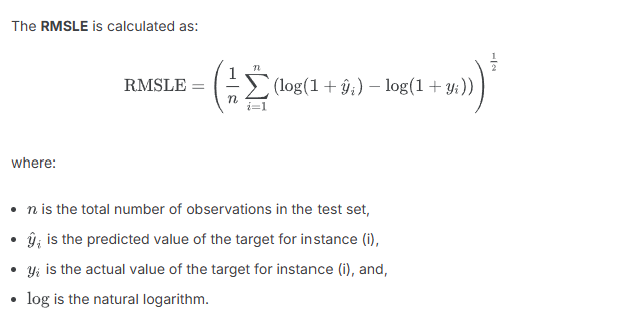

#### Submision

For each `id` row in the test set, you must predict the continuous target, `Calories`. The file should contain a header and have the following format:

```
id,Calories
750000,93.2
750001,27.42
750002,103.8
etc.
```

In [3]:
# Reusable code to extract the contents from the zip file 

import zipfile
import os

zip_path = "data/playground-series-s5e5.zip"
extract_dir = "data/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Files extracted to:", extract_dir)

Files extracted to: data/


In [36]:
# Perform intial EDA to understand the data
import pandas as pd

# Path of the training file to read
train_file_path = 'data/train.csv'
train_data = pd.read_csv(train_file_path)


# Path of the training file to read
test_file_path = 'data/test.csv'
test_data = pd.read_csv(test_file_path)

# print(train_data.columns)
# print(train_data.head)

train_has_zero_in_height = (train_data['Height'] == 0).any()
test_has_zero_in_height = (test_data['Height'] == 0).any()
print("Are there any zeroes in Height? ", train_has_zero_in_height)
print("Are there any zeroes in Height? ", test_has_zero_in_height)

# print(train_data.columns)
# print(train_data.head)

## This gives the number of missing values per column
# nan_count_per_column = train_data.isna().sum()
# print(nan_count_per_column)

# Check if any value in the DataFrame is NaN
has_nan = train_data.isna().any().any()
print("Does the training data contain any missing values: ", has_nan)

# Check if any value in the test DataFrame is NaN
test_has_nan = test_data.isna().any().any()
print("Does the test data contain any missing values: ", test_has_nan)

Are there any zeroes in Height?  False
Are there any zeroes in Height?  False
Does the training data contain any missing values:  False
Does the test data contain any missing values:  False


In [46]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
train_data['Sex_encoded'] = encoder.fit_transform(train_data['Sex'])
test_data['Sex_encoded'] = encoder.fit_transform(test_data['Sex'])

train_data['BMI'] = train_data['Weight']/(train_data['Weight']) ** 2
test_data['BMI'] = test_data['Weight']/(test_data['Weight']) ** 2

In [47]:
# Select the features to train the model
feature_columns = ['Sex_encoded', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI']
X = train_data[feature_columns]
y = train_data.Calories

print(X.head)
print(y.head)

# Split training data into separate sets for training and prediction
# Note: Avoiding predicting on the trained data to avoid overfitting conditions
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

test_X = test_data[feature_columns]

<bound method NDFrame.head of         Sex_encoded  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  \
0                 1   36   189.0    82.0      26.0       101.0       41.0   
1                 0   64   163.0    60.0       8.0        85.0       39.7   
2                 0   51   161.0    64.0       7.0        84.0       39.8   
3                 1   20   192.0    90.0      25.0       105.0       40.7   
4                 0   38   166.0    61.0      25.0       102.0       40.6   
...             ...  ...     ...     ...       ...         ...        ...   
749995            1   28   193.0    97.0      30.0       114.0       40.9   
749996            0   64   165.0    63.0      18.0        92.0       40.5   
749997            1   60   162.0    67.0      29.0       113.0       40.9   
749998            1   45   182.0    91.0      17.0       102.0       40.3   
749999            0   39   171.0    65.0      19.0        97.0       40.6   

             BMI  
0       0.012195  
1      

In [48]:
# Linear Regression Model
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

y_pred = linear_regression_model.predict(X_val)

# Make sure no negative values
y_val = np.maximum(0, y_val)
y_pred = np.maximum(0, y_pred)

# # Calculate RMSLE (for evaluation)
rmsle = np.sqrt(mean_squared_log_error(y_val, y_pred))
print(f"RMSLE: {rmsle}")

# Final prediction on the test dataset
test_preds = linear_regression_model.predict(test_X)

# Save predictions for submission
submission = pd.DataFrame({'id': test_data['id'], 'Calories': test_preds})
submission.to_csv('submission.csv', index=False)

RMSLE: 0.5667351080889285


In [49]:
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = np.maximum(0, model.predict(X_val))  # prevent negatives for RMSLE
    rmsle = mean_squared_log_error(y_val, preds) ** 0.5
    print(f"{name} RMSLE: {rmsle:.4f}")


Linear Regression RMSLE: 0.5667
Ridge RMSLE: 0.5648
Lasso RMSLE: 0.5963
Random Forest RMSLE: 0.0797
Gradient Boosting RMSLE: 0.1294


In [50]:
# Optional: Set same params as before
final_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)

# Train on full training set
final_model.fit(X, y)

# avoid negatives for RMSLE-style problems
final_preds = np.maximum(0, final_model.predict(test_X))

submission = pd.DataFrame({
    "id": test_data["id"],   # Adjust this if your ID column has a different name
    "Calories": final_preds
})

submission.to_csv("submission.csv", index=False)

In [53]:
!pip install xgboost
!pip install lightgbm


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_preds = np.maximum(0, xgb_model.predict(X_val))
xgb_rmsle = mean_squared_log_error(y_val, xgb_preds) ** 0.5
print("XGBoost RMSLE:", xgb_rmsle)

# avoid negatives for RMSLE-style problems
final_preds = np.maximum(0, xgb_model.predict(test_X))

submission = pd.DataFrame({
    "id": test_data["id"],   # Adjust this if your ID column has a different name
    "Calories": final_preds
})

submission.to_csv("submission.csv", index=False)

XGBoost RMSLE: 0.0620716329224863


In [57]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train)
lgb_preds = np.maximum(0, lgb_model.predict(X_val))
lgb_rmsle = mean_squared_log_error(y_val, lgb_preds) ** 0.5
print("LightGBM RMSLE:", lgb_rmsle)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 8
[LightGBM] [Info] Start training from score 88.298465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM RMSLE: 0.06344439745100533


In [62]:
!pip install tensorflow


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Step 1: Scale the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 3: Build the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Step 4: Compile the model
model.compile(optimizer='adam', loss='mean_squared_logarithmic_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Step 5: Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Predict and calculate RMSLE manually
y_pred = model.predict(X_val).flatten()
y_pred = np.maximum(0, y_pred)

from sklearn.metrics import mean_squared_log_error
rmsle = mean_squared_log_error(y_val, y_pred) ** 0.5
print("Neural Network RMSLE:", rmsle)

C:\Users\tejar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 0.0935 - root_mean_squared_error: 15.0599 - val_loss: 0.0043 - val_root_mean_squared_error: 4.0196
Epoch 2/100
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - loss: 0.0043 - root_mean_squared_error: 3.8207 - val_loss: 0.0040 - val_root_mean_squared_error: 3.7144
Epoch 3/100
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.0042 - root_mean_squared_error: 3.7789 - val_loss: 0.0041 - val_root_mean_squared_error: 3.7356
Epoch 4/100
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.0041 - root_mean_squared_error: 3.7623 - val_loss: 0.0042 - val_root_mean_squared_error: 3.7255
Epoch 5/100
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.0041 - root_mean_squared_error: 3.7472 - val_loss: 0.0039 - val_root_mean_squared_error: 3.7877
Epoch 6/100
18750/18750 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 0.0040 - root_mean_squared_error: 3.7336 - val_loss: 0.0039 - val_root_mean_squared_error: 3.7156
Epoch 7/100
187

In [65]:
# avoid negatives for RMSLE-style problems
final_preds = np.maximum(0, model.predict(test_X).flatten())

submission = pd.DataFrame({
    "id": test_data["id"],   # Adjust this if your ID column has a different name
    "Calories": final_preds
})

submission.to_csv("submission.csv", index=False)

7813/7813 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
